In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'VTCNN2_dft'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Discrete Fourier Transform

Each signal is transformed from an I/Q sample using Discrete Fourier Transform, and added as a column to the dataset.

In [7]:
def I_Q_to_DFT(signal):
    complex_IQ_representation = []
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)
        complex_IQ_representation.append(cmplx)
    
    # numpy fft(arr) transforms an array 'arr' of complex numbers using Discrete Fourier Transform
    ffted_cplx = np.fft.fft(complex_IQ_representation)
    return [ffted_cplx.real, ffted_cplx.imag]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_DFT(signal)
    
    # transformed_signal is a train of values
    transformed_signals.append(transformed_signal)

In [9]:
dft_signals_column_dataframe_name = 'DFT signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[dft_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    dft_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding DFT Signals

In [10]:
dataset_df

,IQ signals,DFT signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[-0.060862621969135944, -0.22769021567320955,...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.07303547981427982, 0.21388404694926202, -0...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.07157310681941453, 0.06983173884925772, -0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.06919694535099552, 0.05751631710576523, -0...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.16920786396804033, 0.3561287889109632, 0.3...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[-0.02215634343883721, 0.11752126689233586, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[-0.10105456630867593, -0.10305432796774971, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[-0.0646182048258197, 0.0054176624689576194, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[-0.16591021459316835, 0.001243809761688204, ...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = dataset_df[dft_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 2, 128)
[2, 128]


In [16]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 29:16 - loss: 2.3972

  8/151 [>.............................] - ETA: 1s - loss: 2.3972   

 16/151 [==>...........................] - ETA: 0s - loss: 2.3955

 24/151 [===>..........................] - ETA: 0s - loss: 2.3924

 32/151 [=====>........................] - ETA: 0s - loss: 2.3873

 40/151 [======>.......................] - ETA: 0s - loss: 2.3801

 48/151 [========>.....................] - ETA: 0s - loss: 2.3723

 57/151 [==========>...................] - ETA: 0s - loss: 2.3637

 65/151 [===========>..................] - ETA: 0s - loss: 2.3563

 73/151 [=============>................] - ETA: 0s - loss: 2.3495

 82/151 [===============>..............] - ETA: 0s - loss: 2.3423



 91/151 [=================>............] - ETA: 0s - loss: 2.3357

 99/151 [==================>...........] - ETA: 0s - loss: 2.3302

108/151 [====================>.........] - ETA: 0s - loss: 2.3243

117/151 [======================>.......] - ETA: 0s - loss: 2.3186

126/151 [========================>.....] - ETA: 0s - loss: 2.3132

135/151 [=========================>....] - ETA: 0s - loss: 2.3077

143/151 [===========================>..] - ETA: 0s - loss: 2.3030

151/151 [==============================] - ETA: 0s - loss: 2.2983

151/151 [==============================] - 13s 11ms/step - loss: 2.2977 - val_loss: 2.0024


Epoch 2/100
  1/151 [..............................] - ETA: 1s - loss: 2.0522

  9/151 [>.............................] - ETA: 0s - loss: 2.0613

 17/151 [==>...........................] - ETA: 0s - loss: 2.0573

 26/151 [====>.........................] - ETA: 0s - loss: 2.0542

 34/151 [=====>........................] - ETA: 0s - loss: 2.0518

 42/151 [=======>......................] - ETA: 0s - loss: 2.0491

 51/151 [=========>....................] - ETA: 0s - loss: 2.0464

 60/151 [==========>...................] - ETA: 0s - loss: 2.0440

 69/151 [============>.................] - ETA: 0s - loss: 2.0415

 77/151 [==============>...............] - ETA: 0s - loss: 2.0393

 86/151 [================>.............] - ETA: 0s - loss: 2.0369

 95/151 [=================>............] - ETA: 0s - loss: 2.0346

104/151 [===================>..........] - ETA: 0s - loss: 2.0325

112/151 [=====================>........] - ETA: 0s - loss: 2.0306

121/151 [=======================>......] - ETA: 0s - loss: 2.0286

130/151 [========================>.....] - ETA: 0s - loss: 2.0266

139/151 [==========================>...] - ETA: 0s - loss: 2.0246

148/151 [============================>.] - ETA: 0s - loss: 2.0228



151/151 [==============================] - 1s 7ms/step - loss: 2.0219 - val_loss: 1.8722


Epoch 3/100
  1/151 [..............................] - ETA: 0s - loss: 1.9180



 10/151 [>.............................] - ETA: 0s - loss: 1.9139

 19/151 [==>...........................] - ETA: 0s - loss: 1.9170

 28/151 [====>.........................] - ETA: 0s - loss: 1.9180



 37/151 [======>.......................] - ETA: 0s - loss: 1.9182

 46/151 [========>.....................] - ETA: 0s - loss: 1.9183

 55/151 [=========>....................] - ETA: 0s - loss: 1.9184

 63/151 [===========>..................] - ETA: 0s - loss: 1.9182

 71/151 [=============>................] - ETA: 0s - loss: 1.9179

 79/151 [==============>...............] - ETA: 0s - loss: 1.9176

 88/151 [================>.............] - ETA: 0s - loss: 1.9172

 97/151 [==================>...........] - ETA: 0s - loss: 1.9169

106/151 [====================>.........] - ETA: 0s - loss: 1.9166

115/151 [=====================>........] - ETA: 0s - loss: 1.9163

123/151 [=======================>......] - ETA: 0s - loss: 1.9159

132/151 [=========================>....] - ETA: 0s - loss: 1.9155

141/151 [===========================>..] - ETA: 0s - loss: 1.9151

149/151 [============================>.] - ETA: 0s - loss: 1.9148



151/151 [==============================] - 1s 7ms/step - loss: 1.9146 - val_loss: 1.8307


Epoch 4/100
  1/151 [..............................] - ETA: 1s - loss: 1.8516

  9/151 [>.............................] - ETA: 0s - loss: 1.8719

 18/151 [==>...........................] - ETA: 0s - loss: 1.8733

 27/151 [====>.........................] - ETA: 0s - loss: 1.8738

 36/151 [======>.......................] - ETA: 0s - loss: 1.8738

 45/151 [=======>......................] - ETA: 0s - loss: 1.8742

 53/151 [=========>....................] - ETA: 0s - loss: 1.8745

 62/151 [===========>..................] - ETA: 0s - loss: 1.8746

 70/151 [============>.................] - ETA: 0s - loss: 1.8747

 77/151 [==============>...............] - ETA: 0s - loss: 1.8748



 84/151 [===============>..............] - ETA: 0s - loss: 1.8750

 91/151 [=================>............] - ETA: 0s - loss: 1.8750

 98/151 [==================>...........] - ETA: 0s - loss: 1.8750

106/151 [====================>.........] - ETA: 0s - loss: 1.8750



115/151 [=====================>........] - ETA: 0s - loss: 1.8749

123/151 [=======================>......] - ETA: 0s - loss: 1.8748

131/151 [=========================>....] - ETA: 0s - loss: 1.8747

139/151 [==========================>...] - ETA: 0s - loss: 1.8746

147/151 [============================>.] - ETA: 0s - loss: 1.8744

151/151 [==============================] - 1s 8ms/step - loss: 1.8743 - val_loss: 1.7980


Epoch 5/100
  1/151 [..............................] - ETA: 1s - loss: 1.9028

  8/151 [>.............................] - ETA: 1s - loss: 1.8531



 15/151 [=>............................] - ETA: 1s - loss: 1.8462

 22/151 [===>..........................] - ETA: 0s - loss: 1.8455

 29/151 [====>.........................] - ETA: 0s - loss: 1.8453

 37/151 [======>.......................] - ETA: 0s - loss: 1.8447

 44/151 [=======>......................] - ETA: 0s - loss: 1.8444

 51/151 [=========>....................] - ETA: 0s - loss: 1.8442



 57/151 [==========>...................] - ETA: 0s - loss: 1.8440

 63/151 [===========>..................] - ETA: 0s - loss: 1.8438

 69/151 [============>.................] - ETA: 0s - loss: 1.8438



 77/151 [==============>...............] - ETA: 0s - loss: 1.8436

 85/151 [===============>..............] - ETA: 0s - loss: 1.8435



 93/151 [=================>............] - ETA: 0s - loss: 1.8433

101/151 [===================>..........] - ETA: 0s - loss: 1.8432

110/151 [====================>.........] - ETA: 0s - loss: 1.8431

119/151 [======================>.......] - ETA: 0s - loss: 1.8429

127/151 [========================>.....] - ETA: 0s - loss: 1.8427



135/151 [=========================>....] - ETA: 0s - loss: 1.8425

144/151 [===========================>..] - ETA: 0s - loss: 1.8423

151/151 [==============================] - 1s 8ms/step - loss: 1.8421 - val_loss: 1.7675


Epoch 6/100
  1/151 [..............................] - ETA: 1s - loss: 1.8210

 10/151 [>.............................] - ETA: 0s - loss: 1.8140

 19/151 [==>...........................] - ETA: 0s - loss: 1.8159

 28/151 [====>.........................] - ETA: 0s - loss: 1.8175

 37/151 [======>.......................] - ETA: 0s - loss: 1.8185

 46/151 [========>.....................] - ETA: 0s - loss: 1.8194

 55/151 [=========>....................] - ETA: 0s - loss: 1.8201

 64/151 [===========>..................] - ETA: 0s - loss: 1.8204

 73/151 [=============>................] - ETA: 0s - loss: 1.8205

 82/151 [===============>..............] - ETA: 0s - loss: 1.8205

 91/151 [=================>............] - ETA: 0s - loss: 1.8205

 99/151 [==================>...........] - ETA: 0s - loss: 1.8204

107/151 [====================>.........] - ETA: 0s - loss: 1.8203

116/151 [======================>.......] - ETA: 0s - loss: 1.8200

124/151 [=======================>......] - ETA: 0s - loss: 1.8198

132/151 [=========================>....] - ETA: 0s - loss: 1.8196

141/151 [===========================>..] - ETA: 0s - loss: 1.8194

149/151 [============================>.] - ETA: 0s - loss: 1.8192

151/151 [==============================] - 1s 7ms/step - loss: 1.8191 - val_loss: 1.7519


Epoch 7/100
  1/151 [..............................] - ETA: 1s - loss: 1.7985

 10/151 [>.............................] - ETA: 0s - loss: 1.8038

 19/151 [==>...........................] - ETA: 0s - loss: 1.7984

 28/151 [====>.........................] - ETA: 0s - loss: 1.7966

 36/151 [======>.......................] - ETA: 0s - loss: 1.7963

 44/151 [=======>......................] - ETA: 0s - loss: 1.7964

 53/151 [=========>....................] - ETA: 0s - loss: 1.7964

 62/151 [===========>..................] - ETA: 0s - loss: 1.7963

 70/151 [============>.................] - ETA: 0s - loss: 1.7965

 79/151 [==============>...............] - ETA: 0s - loss: 1.7966

 87/151 [================>.............] - ETA: 0s - loss: 1.7967

 96/151 [==================>...........] - ETA: 0s - loss: 1.7968



105/151 [===================>..........] - ETA: 0s - loss: 1.7969

114/151 [=====================>........] - ETA: 0s - loss: 1.7969



122/151 [=======================>......] - ETA: 0s - loss: 1.7969

131/151 [=========================>....] - ETA: 0s - loss: 1.7969

140/151 [==========================>...] - ETA: 0s - loss: 1.7969

148/151 [============================>.] - ETA: 0s - loss: 1.7970

151/151 [==============================] - 1s 7ms/step - loss: 1.7970 - val_loss: 1.7362


Epoch 8/100
  1/151 [..............................] - ETA: 1s - loss: 1.7857

  9/151 [>.............................] - ETA: 0s - loss: 1.7969



 18/151 [==>...........................] - ETA: 0s - loss: 1.7925

 27/151 [====>.........................] - ETA: 0s - loss: 1.7888

 35/151 [=====>........................] - ETA: 0s - loss: 1.7876

 44/151 [=======>......................] - ETA: 0s - loss: 1.7869

 53/151 [=========>....................] - ETA: 0s - loss: 1.7863

 61/151 [===========>..................] - ETA: 0s - loss: 1.7859

 69/151 [============>.................] - ETA: 0s - loss: 1.7856

 77/151 [==============>...............] - ETA: 0s - loss: 1.7853

 85/151 [===============>..............] - ETA: 0s - loss: 1.7852

 93/151 [=================>............] - ETA: 0s - loss: 1.7851

101/151 [===================>..........] - ETA: 0s - loss: 1.7850



109/151 [====================>.........] - ETA: 0s - loss: 1.7849

117/151 [======================>.......] - ETA: 0s - loss: 1.7848

125/151 [=======================>......] - ETA: 0s - loss: 1.7847

134/151 [=========================>....] - ETA: 0s - loss: 1.7846

143/151 [===========================>..] - ETA: 0s - loss: 1.7846

151/151 [==============================] - 1s 7ms/step - loss: 1.7845 - val_loss: 1.7220


Epoch 9/100
  1/151 [..............................] - ETA: 1s - loss: 1.7970

  9/151 [>.............................] - ETA: 0s - loss: 1.7844

 18/151 [==>...........................] - ETA: 0s - loss: 1.7765

 26/151 [====>.........................] - ETA: 0s - loss: 1.7758

 35/151 [=====>........................] - ETA: 0s - loss: 1.7757

 43/151 [=======>......................] - ETA: 0s - loss: 1.7758

 51/151 [=========>....................] - ETA: 0s - loss: 1.7761

 59/151 [==========>...................] - ETA: 0s - loss: 1.7760

 67/151 [============>.................] - ETA: 0s - loss: 1.7758

 76/151 [==============>...............] - ETA: 0s - loss: 1.7757

 85/151 [===============>..............] - ETA: 0s - loss: 1.7757

 93/151 [=================>............] - ETA: 0s - loss: 1.7757

102/151 [===================>..........] - ETA: 0s - loss: 1.7757

111/151 [=====================>........] - ETA: 0s - loss: 1.7758

119/151 [======================>.......] - ETA: 0s - loss: 1.7758

127/151 [========================>.....] - ETA: 0s - loss: 1.7759

135/151 [=========================>....] - ETA: 0s - loss: 1.7759

144/151 [===========================>..] - ETA: 0s - loss: 1.7758

151/151 [==============================] - 1s 7ms/step - loss: 1.7758 - val_loss: 1.7132


Epoch 10/100
  1/151 [..............................] - ETA: 1s - loss: 1.7757

 10/151 [>.............................] - ETA: 0s - loss: 1.7666

 18/151 [==>...........................] - ETA: 0s - loss: 1.7653

 27/151 [====>.........................] - ETA: 0s - loss: 1.7665

 35/151 [=====>........................] - ETA: 0s - loss: 1.7675

 43/151 [=======>......................] - ETA: 0s - loss: 1.7681

 51/151 [=========>....................] - ETA: 0s - loss: 1.7687

 59/151 [==========>...................] - ETA: 0s - loss: 1.7689

 68/151 [============>.................] - ETA: 0s - loss: 1.7685

 76/151 [==============>...............] - ETA: 0s - loss: 1.7681

 84/151 [===============>..............] - ETA: 0s - loss: 1.7680

 93/151 [=================>............] - ETA: 0s - loss: 1.7678

102/151 [===================>..........] - ETA: 0s - loss: 1.7677

111/151 [=====================>........] - ETA: 0s - loss: 1.7676

120/151 [======================>.......] - ETA: 0s - loss: 1.7674

129/151 [========================>.....] - ETA: 0s - loss: 1.7673

137/151 [==========================>...] - ETA: 0s - loss: 1.7672

145/151 [===========================>..] - ETA: 0s - loss: 1.7671

151/151 [==============================] - 1s 7ms/step - loss: 1.7670 - val_loss: 1.7061


Epoch 11/100
  1/151 [..............................] - ETA: 1s - loss: 1.7324



  9/151 [>.............................] - ETA: 0s - loss: 1.7414

 17/151 [==>...........................] - ETA: 0s - loss: 1.7414

 25/151 [===>..........................] - ETA: 0s - loss: 1.7442

 34/151 [=====>........................] - ETA: 0s - loss: 1.7460

 42/151 [=======>......................] - ETA: 0s - loss: 1.7472

 51/151 [=========>....................] - ETA: 0s - loss: 1.7487

 59/151 [==========>...................] - ETA: 0s - loss: 1.7499

 67/151 [============>.................] - ETA: 0s - loss: 1.7506

 75/151 [=============>................] - ETA: 0s - loss: 1.7513

 84/151 [===============>..............] - ETA: 0s - loss: 1.7521

 93/151 [=================>............] - ETA: 0s - loss: 1.7527

101/151 [===================>..........] - ETA: 0s - loss: 1.7532

110/151 [====================>.........] - ETA: 0s - loss: 1.7537

118/151 [======================>.......] - ETA: 0s - loss: 1.7541

126/151 [========================>.....] - ETA: 0s - loss: 1.7545

134/151 [=========================>....] - ETA: 0s - loss: 1.7548

142/151 [===========================>..] - ETA: 0s - loss: 1.7551

150/151 [============================>.] - ETA: 0s - loss: 1.7554

151/151 [==============================] - 1s 8ms/step - loss: 1.7555 - val_loss: 1.7029


Epoch 12/100
  1/151 [..............................] - ETA: 1s - loss: 1.6885

  9/151 [>.............................] - ETA: 0s - loss: 1.7282

 18/151 [==>...........................] - ETA: 0s - loss: 1.7342

 27/151 [====>.........................] - ETA: 0s - loss: 1.7378

 35/151 [=====>........................] - ETA: 0s - loss: 1.7399

 44/151 [=======>......................] - ETA: 0s - loss: 1.7417

 52/151 [=========>....................] - ETA: 0s - loss: 1.7431

 60/151 [==========>...................] - ETA: 0s - loss: 1.7442

 69/151 [============>.................] - ETA: 0s - loss: 1.7450

 77/151 [==============>...............] - ETA: 0s - loss: 1.7454

 86/151 [================>.............] - ETA: 0s - loss: 1.7459

 94/151 [=================>............] - ETA: 0s - loss: 1.7462

103/151 [===================>..........] - ETA: 0s - loss: 1.7466

111/151 [=====================>........] - ETA: 0s - loss: 1.7468

119/151 [======================>.......] - ETA: 0s - loss: 1.7471

128/151 [========================>.....] - ETA: 0s - loss: 1.7474

137/151 [==========================>...] - ETA: 0s - loss: 1.7476

146/151 [============================>.] - ETA: 0s - loss: 1.7480

151/151 [==============================] - 1s 7ms/step - loss: 1.7482 - val_loss: 1.7020


Epoch 13/100
  1/151 [..............................] - ETA: 1s - loss: 1.7309

 10/151 [>.............................] - ETA: 0s - loss: 1.7457

 19/151 [==>...........................] - ETA: 0s - loss: 1.7435

 27/151 [====>.........................] - ETA: 0s - loss: 1.7435

 36/151 [======>.......................] - ETA: 0s - loss: 1.7435

 45/151 [=======>......................] - ETA: 0s - loss: 1.7443

 54/151 [=========>....................] - ETA: 0s - loss: 1.7449

 63/151 [===========>..................] - ETA: 0s - loss: 1.7454

 72/151 [=============>................] - ETA: 0s - loss: 1.7459

 80/151 [==============>...............] - ETA: 0s - loss: 1.7463

 89/151 [================>.............] - ETA: 0s - loss: 1.7466

 97/151 [==================>...........] - ETA: 0s - loss: 1.7468

106/151 [====================>.........] - ETA: 0s - loss: 1.7470

115/151 [=====================>........] - ETA: 0s - loss: 1.7473

124/151 [=======================>......] - ETA: 0s - loss: 1.7476

133/151 [=========================>....] - ETA: 0s - loss: 1.7478

141/151 [===========================>..] - ETA: 0s - loss: 1.7479

149/151 [============================>.] - ETA: 0s - loss: 1.7480

151/151 [==============================] - 1s 7ms/step - loss: 1.7481 - val_loss: 1.6964


Epoch 14/100
  1/151 [..............................] - ETA: 1s - loss: 1.7152

  9/151 [>.............................] - ETA: 0s - loss: 1.7293

 18/151 [==>...........................] - ETA: 0s - loss: 1.7340



 27/151 [====>.........................] - ETA: 0s - loss: 1.7369

 36/151 [======>.......................] - ETA: 0s - loss: 1.7390

 45/151 [=======>......................] - ETA: 0s - loss: 1.7407

 54/151 [=========>....................] - ETA: 0s - loss: 1.7415

 63/151 [===========>..................] - ETA: 0s - loss: 1.7422

 71/151 [=============>................] - ETA: 0s - loss: 1.7427

 80/151 [==============>...............] - ETA: 0s - loss: 1.7432

 89/151 [================>.............] - ETA: 0s - loss: 1.7435

 98/151 [==================>...........] - ETA: 0s - loss: 1.7437

106/151 [====================>.........] - ETA: 0s - loss: 1.7438

115/151 [=====================>........] - ETA: 0s - loss: 1.7440

123/151 [=======================>......] - ETA: 0s - loss: 1.7441

132/151 [=========================>....] - ETA: 0s - loss: 1.7442

141/151 [===========================>..] - ETA: 0s - loss: 1.7443

149/151 [============================>.] - ETA: 0s - loss: 1.7444

151/151 [==============================] - 1s 7ms/step - loss: 1.7444 - val_loss: 1.6953


Epoch 15/100
  1/151 [..............................] - ETA: 1s - loss: 1.7375

  9/151 [>.............................] - ETA: 0s - loss: 1.7352

 17/151 [==>...........................] - ETA: 0s - loss: 1.7372

 26/151 [====>.........................] - ETA: 0s - loss: 1.7384

 35/151 [=====>........................] - ETA: 0s - loss: 1.7391

 43/151 [=======>......................] - ETA: 0s - loss: 1.7397

 52/151 [=========>....................] - ETA: 0s - loss: 1.7401

 60/151 [==========>...................] - ETA: 0s - loss: 1.7402

 69/151 [============>.................] - ETA: 0s - loss: 1.7403

 78/151 [==============>...............] - ETA: 0s - loss: 1.7402

 86/151 [================>.............] - ETA: 0s - loss: 1.7401

 94/151 [=================>............] - ETA: 0s - loss: 1.7400

103/151 [===================>..........] - ETA: 0s - loss: 1.7400

112/151 [=====================>........] - ETA: 0s - loss: 1.7400

121/151 [=======================>......] - ETA: 0s - loss: 1.7400

130/151 [========================>.....] - ETA: 0s - loss: 1.7400

139/151 [==========================>...] - ETA: 0s - loss: 1.7400

147/151 [============================>.] - ETA: 0s - loss: 1.7400

151/151 [==============================] - 1s 7ms/step - loss: 1.7400 - val_loss: 1.6920


Epoch 16/100
  1/151 [..............................] - ETA: 0s - loss: 1.7199

 10/151 [>.............................] - ETA: 0s - loss: 1.7207

 18/151 [==>...........................] - ETA: 0s - loss: 1.7250

 26/151 [====>.........................] - ETA: 0s - loss: 1.7269

 34/151 [=====>........................] - ETA: 0s - loss: 1.7287



 42/151 [=======>......................] - ETA: 0s - loss: 1.7307

 50/151 [========>.....................] - ETA: 0s - loss: 1.7321

 59/151 [==========>...................] - ETA: 0s - loss: 1.7333

 67/151 [============>.................] - ETA: 0s - loss: 1.7343

 76/151 [==============>...............] - ETA: 0s - loss: 1.7349

 84/151 [===============>..............] - ETA: 0s - loss: 1.7353

 92/151 [=================>............] - ETA: 0s - loss: 1.7356

101/151 [===================>..........] - ETA: 0s - loss: 1.7359

109/151 [====================>.........] - ETA: 0s - loss: 1.7362

118/151 [======================>.......] - ETA: 0s - loss: 1.7364

126/151 [========================>.....] - ETA: 0s - loss: 1.7365

134/151 [=========================>....] - ETA: 0s - loss: 1.7366

143/151 [===========================>..] - ETA: 0s - loss: 1.7366

151/151 [==============================] - 1s 8ms/step - loss: 1.7367 - val_loss: 1.6900


Epoch 17/100
  1/151 [..............................] - ETA: 1s - loss: 1.7297

  9/151 [>.............................] - ETA: 0s - loss: 1.7317

 17/151 [==>...........................] - ETA: 0s - loss: 1.7318

 25/151 [===>..........................] - ETA: 0s - loss: 1.7307

 34/151 [=====>........................] - ETA: 0s - loss: 1.7298

 43/151 [=======>......................] - ETA: 0s - loss: 1.7296



 51/151 [=========>....................] - ETA: 0s - loss: 1.7294

 59/151 [==========>...................] - ETA: 0s - loss: 1.7294

 67/151 [============>.................] - ETA: 0s - loss: 1.7295



 75/151 [=============>................] - ETA: 0s - loss: 1.7296

 83/151 [===============>..............] - ETA: 0s - loss: 1.7298

 91/151 [=================>............] - ETA: 0s - loss: 1.7300

100/151 [==================>...........] - ETA: 0s - loss: 1.7302

108/151 [====================>.........] - ETA: 0s - loss: 1.7303

116/151 [======================>.......] - ETA: 0s - loss: 1.7305

125/151 [=======================>......] - ETA: 0s - loss: 1.7307

134/151 [=========================>....] - ETA: 0s - loss: 1.7309

143/151 [===========================>..] - ETA: 0s - loss: 1.7312

151/151 [==============================] - 1s 7ms/step - loss: 1.7314 - val_loss: 1.6880


Epoch 18/100
  1/151 [..............................] - ETA: 1s - loss: 1.7717

  9/151 [>.............................] - ETA: 0s - loss: 1.7383

 18/151 [==>...........................] - ETA: 0s - loss: 1.7321

 26/151 [====>.........................] - ETA: 0s - loss: 1.7297



 34/151 [=====>........................] - ETA: 0s - loss: 1.7282

 42/151 [=======>......................] - ETA: 0s - loss: 1.7273

 50/151 [========>.....................] - ETA: 0s - loss: 1.7271



 58/151 [==========>...................] - ETA: 0s - loss: 1.7270

 67/151 [============>.................] - ETA: 0s - loss: 1.7272

 76/151 [==============>...............] - ETA: 0s - loss: 1.7273

 84/151 [===============>..............] - ETA: 0s - loss: 1.7275

 92/151 [=================>............] - ETA: 0s - loss: 1.7277

101/151 [===================>..........] - ETA: 0s - loss: 1.7280

109/151 [====================>.........] - ETA: 0s - loss: 1.7282

117/151 [======================>.......] - ETA: 0s - loss: 1.7284

125/151 [=======================>......] - ETA: 0s - loss: 1.7285

133/151 [=========================>....] - ETA: 0s - loss: 1.7286

140/151 [==========================>...] - ETA: 0s - loss: 1.7286

148/151 [============================>.] - ETA: 0s - loss: 1.7288

151/151 [==============================] - 1s 8ms/step - loss: 1.7288 - val_loss: 1.6871


Epoch 19/100
  1/151 [..............................] - ETA: 2s - loss: 1.7184

  9/151 [>.............................] - ETA: 0s - loss: 1.7193

 18/151 [==>...........................] - ETA: 0s - loss: 1.7199

 27/151 [====>.........................] - ETA: 0s - loss: 1.7209

 35/151 [=====>........................] - ETA: 0s - loss: 1.7211

 44/151 [=======>......................] - ETA: 0s - loss: 1.7213

 52/151 [=========>....................] - ETA: 0s - loss: 1.7216

 60/151 [==========>...................] - ETA: 0s - loss: 1.7219

 68/151 [============>.................] - ETA: 0s - loss: 1.7221

 76/151 [==============>...............] - ETA: 0s - loss: 1.7225

 85/151 [===============>..............] - ETA: 0s - loss: 1.7232

 94/151 [=================>............] - ETA: 0s - loss: 1.7238

102/151 [===================>..........] - ETA: 0s - loss: 1.7243

111/151 [=====================>........] - ETA: 0s - loss: 1.7248

119/151 [======================>.......] - ETA: 0s - loss: 1.7251



127/151 [========================>.....] - ETA: 0s - loss: 1.7255

135/151 [=========================>....] - ETA: 0s - loss: 1.7257



144/151 [===========================>..] - ETA: 0s - loss: 1.7259

151/151 [==============================] - 1s 7ms/step - loss: 1.7261 - val_loss: 1.6871


Epoch 20/100
  1/151 [..............................] - ETA: 1s - loss: 1.7420

  9/151 [>.............................] - ETA: 0s - loss: 1.7258



 18/151 [==>...........................] - ETA: 0s - loss: 1.7278

 27/151 [====>.........................] - ETA: 0s - loss: 1.7285

 35/151 [=====>........................] - ETA: 0s - loss: 1.7291

 44/151 [=======>......................] - ETA: 0s - loss: 1.7291

 52/151 [=========>....................] - ETA: 0s - loss: 1.7292

 60/151 [==========>...................] - ETA: 0s - loss: 1.7293

 69/151 [============>.................] - ETA: 0s - loss: 1.7294

 77/151 [==============>...............] - ETA: 0s - loss: 1.7294

 85/151 [===============>..............] - ETA: 0s - loss: 1.7294

 93/151 [=================>............] - ETA: 0s - loss: 1.7293

101/151 [===================>..........] - ETA: 0s - loss: 1.7293

110/151 [====================>.........] - ETA: 0s - loss: 1.7294

119/151 [======================>.......] - ETA: 0s - loss: 1.7294

128/151 [========================>.....] - ETA: 0s - loss: 1.7293

137/151 [==========================>...] - ETA: 0s - loss: 1.7293

146/151 [============================>.] - ETA: 0s - loss: 1.7292

151/151 [==============================] - 1s 7ms/step - loss: 1.7292 - val_loss: 1.6843


Epoch 21/100
  1/151 [..............................] - ETA: 1s - loss: 1.7095

  9/151 [>.............................] - ETA: 0s - loss: 1.7081

 17/151 [==>...........................] - ETA: 0s - loss: 1.7119

 25/151 [===>..........................] - ETA: 0s - loss: 1.7144

 33/151 [=====>........................] - ETA: 0s - loss: 1.7165

 41/151 [=======>......................] - ETA: 0s - loss: 1.7182

 50/151 [========>.....................] - ETA: 0s - loss: 1.7196

 59/151 [==========>...................] - ETA: 0s - loss: 1.7206

 68/151 [============>.................] - ETA: 0s - loss: 1.7213

 76/151 [==============>...............] - ETA: 0s - loss: 1.7218

 84/151 [===============>..............] - ETA: 0s - loss: 1.7223



 93/151 [=================>............] - ETA: 0s - loss: 1.7228

101/151 [===================>..........] - ETA: 0s - loss: 1.7232

109/151 [====================>.........] - ETA: 0s - loss: 1.7236

118/151 [======================>.......] - ETA: 0s - loss: 1.7239

126/151 [========================>.....] - ETA: 0s - loss: 1.7241

134/151 [=========================>....] - ETA: 0s - loss: 1.7242

142/151 [===========================>..] - ETA: 0s - loss: 1.7243

151/151 [==============================] - ETA: 0s - loss: 1.7243

151/151 [==============================] - 1s 7ms/step - loss: 1.7244 - val_loss: 1.6836


Epoch 22/100
  1/151 [..............................] - ETA: 1s - loss: 1.7173

  9/151 [>.............................] - ETA: 0s - loss: 1.7109

 17/151 [==>...........................] - ETA: 0s - loss: 1.7129

 26/151 [====>.........................] - ETA: 0s - loss: 1.7153

 34/151 [=====>........................] - ETA: 0s - loss: 1.7165

 42/151 [=======>......................] - ETA: 0s - loss: 1.7177

 51/151 [=========>....................] - ETA: 0s - loss: 1.7186

 60/151 [==========>...................] - ETA: 0s - loss: 1.7192

 68/151 [============>.................] - ETA: 0s - loss: 1.7194

 76/151 [==============>...............] - ETA: 0s - loss: 1.7196



 84/151 [===============>..............] - ETA: 0s - loss: 1.7199

 92/151 [=================>............] - ETA: 0s - loss: 1.7201

100/151 [==================>...........] - ETA: 0s - loss: 1.7202

108/151 [====================>.........] - ETA: 0s - loss: 1.7202

116/151 [======================>.......] - ETA: 0s - loss: 1.7203

124/151 [=======================>......] - ETA: 0s - loss: 1.7204

133/151 [=========================>....] - ETA: 0s - loss: 1.7205

142/151 [===========================>..] - ETA: 0s - loss: 1.7206

150/151 [============================>.] - ETA: 0s - loss: 1.7207

151/151 [==============================] - 1s 8ms/step - loss: 1.7207 - val_loss: 1.6818


Epoch 23/100
  1/151 [..............................] - ETA: 1s - loss: 1.7243

  9/151 [>.............................] - ETA: 0s - loss: 1.7263

 17/151 [==>...........................] - ETA: 0s - loss: 1.7245

 25/151 [===>..........................] - ETA: 0s - loss: 1.7230

 33/151 [=====>........................] - ETA: 0s - loss: 1.7216

 42/151 [=======>......................] - ETA: 0s - loss: 1.7208

 50/151 [========>.....................] - ETA: 0s - loss: 1.7202

 58/151 [==========>...................] - ETA: 0s - loss: 1.7200

 66/151 [============>.................] - ETA: 0s - loss: 1.7200

 74/151 [=============>................] - ETA: 0s - loss: 1.7200

 83/151 [===============>..............] - ETA: 0s - loss: 1.7199

 92/151 [=================>............] - ETA: 0s - loss: 1.7199

100/151 [==================>...........] - ETA: 0s - loss: 1.7199

108/151 [====================>.........] - ETA: 0s - loss: 1.7198



116/151 [======================>.......] - ETA: 0s - loss: 1.7198

124/151 [=======================>......] - ETA: 0s - loss: 1.7199

132/151 [=========================>....] - ETA: 0s - loss: 1.7199

140/151 [==========================>...] - ETA: 0s - loss: 1.7199



148/151 [============================>.] - ETA: 0s - loss: 1.7200

151/151 [==============================] - 1s 8ms/step - loss: 1.7200 - val_loss: 1.6834


Epoch 24/100
  1/151 [..............................] - ETA: 0s - loss: 1.6833

 10/151 [>.............................] - ETA: 0s - loss: 1.7020

 18/151 [==>...........................] - ETA: 0s - loss: 1.7090

 27/151 [====>.........................] - ETA: 0s - loss: 1.7120

 36/151 [======>.......................] - ETA: 0s - loss: 1.7141

 45/151 [=======>......................] - ETA: 0s - loss: 1.7155

 54/151 [=========>....................] - ETA: 0s - loss: 1.7166

 62/151 [===========>..................] - ETA: 0s - loss: 1.7173

 70/151 [============>.................] - ETA: 0s - loss: 1.7179

 78/151 [==============>...............] - ETA: 0s - loss: 1.7184

 86/151 [================>.............] - ETA: 0s - loss: 1.7189

 94/151 [=================>............] - ETA: 0s - loss: 1.7192



102/151 [===================>..........] - ETA: 0s - loss: 1.7195

111/151 [=====================>........] - ETA: 0s - loss: 1.7197

119/151 [======================>.......] - ETA: 0s - loss: 1.7200

127/151 [========================>.....] - ETA: 0s - loss: 1.7202

135/151 [=========================>....] - ETA: 0s - loss: 1.7203

143/151 [===========================>..] - ETA: 0s - loss: 1.7203

150/151 [============================>.] - ETA: 0s - loss: 1.7204

151/151 [==============================] - 1s 8ms/step - loss: 1.7204 - val_loss: 1.6836


Epoch 25/100
  1/151 [..............................] - ETA: 0s - loss: 1.7659

  9/151 [>.............................] - ETA: 0s - loss: 1.7305

 17/151 [==>...........................] - ETA: 0s - loss: 1.7267

 26/151 [====>.........................] - ETA: 0s - loss: 1.7226

 35/151 [=====>........................] - ETA: 0s - loss: 1.7205

 43/151 [=======>......................] - ETA: 0s - loss: 1.7201

 52/151 [=========>....................] - ETA: 0s - loss: 1.7202

 61/151 [===========>..................] - ETA: 0s - loss: 1.7204

 69/151 [============>.................] - ETA: 0s - loss: 1.7207

 77/151 [==============>...............] - ETA: 0s - loss: 1.7209

 85/151 [===============>..............] - ETA: 0s - loss: 1.7209

 93/151 [=================>............] - ETA: 0s - loss: 1.7210

101/151 [===================>..........] - ETA: 0s - loss: 1.7209

109/151 [====================>.........] - ETA: 0s - loss: 1.7209

117/151 [======================>.......] - ETA: 0s - loss: 1.7209

125/151 [=======================>......] - ETA: 0s - loss: 1.7209

133/151 [=========================>....] - ETA: 0s - loss: 1.7209

141/151 [===========================>..] - ETA: 0s - loss: 1.7209

149/151 [============================>.] - ETA: 0s - loss: 1.7209

151/151 [==============================] - 1s 8ms/step - loss: 1.7209 - val_loss: 1.6799


Epoch 26/100
  1/151 [..............................] - ETA: 1s - loss: 1.7113

 10/151 [>.............................] - ETA: 0s - loss: 1.7173

 19/151 [==>...........................] - ETA: 0s - loss: 1.7155

 28/151 [====>.........................] - ETA: 0s - loss: 1.7153

 37/151 [======>.......................] - ETA: 0s - loss: 1.7161

 45/151 [=======>......................] - ETA: 0s - loss: 1.7169

 53/151 [=========>....................] - ETA: 0s - loss: 1.7171

 62/151 [===========>..................] - ETA: 0s - loss: 1.7171

 71/151 [=============>................] - ETA: 0s - loss: 1.7169

 79/151 [==============>...............] - ETA: 0s - loss: 1.7168

 87/151 [================>.............] - ETA: 0s - loss: 1.7167

 96/151 [==================>...........] - ETA: 0s - loss: 1.7168

104/151 [===================>..........] - ETA: 0s - loss: 1.7168



112/151 [=====================>........] - ETA: 0s - loss: 1.7168

120/151 [======================>.......] - ETA: 0s - loss: 1.7168

128/151 [========================>.....] - ETA: 0s - loss: 1.7168

136/151 [==========================>...] - ETA: 0s - loss: 1.7168

144/151 [===========================>..] - ETA: 0s - loss: 1.7167

151/151 [==============================] - 1s 7ms/step - loss: 1.7168 - val_loss: 1.6808


Epoch 27/100
  1/151 [..............................] - ETA: 0s - loss: 1.7106

 10/151 [>.............................] - ETA: 0s - loss: 1.7055

 18/151 [==>...........................] - ETA: 0s - loss: 1.7068

 27/151 [====>.........................] - ETA: 0s - loss: 1.7076

 35/151 [=====>........................] - ETA: 0s - loss: 1.7082

 43/151 [=======>......................] - ETA: 0s - loss: 1.7086

 52/151 [=========>....................] - ETA: 0s - loss: 1.7089

 61/151 [===========>..................] - ETA: 0s - loss: 1.7091

 70/151 [============>.................] - ETA: 0s - loss: 1.7095

 78/151 [==============>...............] - ETA: 0s - loss: 1.7098

 86/151 [================>.............] - ETA: 0s - loss: 1.7100

 94/151 [=================>............] - ETA: 0s - loss: 1.7102

103/151 [===================>..........] - ETA: 0s - loss: 1.7105

112/151 [=====================>........] - ETA: 0s - loss: 1.7108

121/151 [=======================>......] - ETA: 0s - loss: 1.7110

129/151 [========================>.....] - ETA: 0s - loss: 1.7112

137/151 [==========================>...] - ETA: 0s - loss: 1.7114

145/151 [===========================>..] - ETA: 0s - loss: 1.7116

151/151 [==============================] - 1s 7ms/step - loss: 1.7118 - val_loss: 1.6798


Epoch 28/100
  1/151 [..............................] - ETA: 1s - loss: 1.7095

  9/151 [>.............................] - ETA: 0s - loss: 1.7231

 18/151 [==>...........................] - ETA: 0s - loss: 1.7196

 26/151 [====>.........................] - ETA: 0s - loss: 1.7179

 35/151 [=====>........................] - ETA: 0s - loss: 1.7167

 43/151 [=======>......................] - ETA: 0s - loss: 1.7160

 52/151 [=========>....................] - ETA: 0s - loss: 1.7156

 60/151 [==========>...................] - ETA: 0s - loss: 1.7154

 68/151 [============>.................] - ETA: 0s - loss: 1.7152

 77/151 [==============>...............] - ETA: 0s - loss: 1.7151

 85/151 [===============>..............] - ETA: 0s - loss: 1.7152

 93/151 [=================>............] - ETA: 0s - loss: 1.7152



101/151 [===================>..........] - ETA: 0s - loss: 1.7153

109/151 [====================>.........] - ETA: 0s - loss: 1.7153

118/151 [======================>.......] - ETA: 0s - loss: 1.7154

126/151 [========================>.....] - ETA: 0s - loss: 1.7154

134/151 [=========================>....] - ETA: 0s - loss: 1.7154

142/151 [===========================>..] - ETA: 0s - loss: 1.7154

150/151 [============================>.] - ETA: 0s - loss: 1.7154

151/151 [==============================] - 1s 7ms/step - loss: 1.7154 - val_loss: 1.6791


Epoch 29/100
  1/151 [..............................] - ETA: 0s - loss: 1.6941

 10/151 [>.............................] - ETA: 0s - loss: 1.7082

 18/151 [==>...........................] - ETA: 0s - loss: 1.7096

 27/151 [====>.........................] - ETA: 0s - loss: 1.7102

 36/151 [======>.......................] - ETA: 0s - loss: 1.7102

 45/151 [=======>......................] - ETA: 0s - loss: 1.7101

 54/151 [=========>....................] - ETA: 0s - loss: 1.7105

 62/151 [===========>..................] - ETA: 0s - loss: 1.7109



 71/151 [=============>................] - ETA: 0s - loss: 1.7113

 80/151 [==============>...............] - ETA: 0s - loss: 1.7117



 89/151 [================>.............] - ETA: 0s - loss: 1.7121

 98/151 [==================>...........] - ETA: 0s - loss: 1.7125



106/151 [====================>.........] - ETA: 0s - loss: 1.7127

115/151 [=====================>........] - ETA: 0s - loss: 1.7130



124/151 [=======================>......] - ETA: 0s - loss: 1.7132

133/151 [=========================>....] - ETA: 0s - loss: 1.7134

141/151 [===========================>..] - ETA: 0s - loss: 1.7135

150/151 [============================>.] - ETA: 0s - loss: 1.7137

151/151 [==============================] - 1s 7ms/step - loss: 1.7137 - val_loss: 1.6804


Epoch 30/100
  1/151 [..............................] - ETA: 1s - loss: 1.6818

  9/151 [>.............................] - ETA: 1s - loss: 1.7088

 17/151 [==>...........................] - ETA: 0s - loss: 1.7121

 26/151 [====>.........................] - ETA: 0s - loss: 1.7132

 34/151 [=====>........................] - ETA: 0s - loss: 1.7130



 42/151 [=======>......................] - ETA: 0s - loss: 1.7127

 50/151 [========>.....................] - ETA: 0s - loss: 1.7123

 59/151 [==========>...................] - ETA: 0s - loss: 1.7120



 67/151 [============>.................] - ETA: 0s - loss: 1.7119

 76/151 [==============>...............] - ETA: 0s - loss: 1.7118



 85/151 [===============>..............] - ETA: 0s - loss: 1.7118

 94/151 [=================>............] - ETA: 0s - loss: 1.7120

102/151 [===================>..........] - ETA: 0s - loss: 1.7121

110/151 [====================>.........] - ETA: 0s - loss: 1.7121

119/151 [======================>.......] - ETA: 0s - loss: 1.7121

128/151 [========================>.....] - ETA: 0s - loss: 1.7121

137/151 [==========================>...] - ETA: 0s - loss: 1.7121

146/151 [============================>.] - ETA: 0s - loss: 1.7121



151/151 [==============================] - 1s 7ms/step - loss: 1.7121 - val_loss: 1.6783


Epoch 31/100
  1/151 [..............................] - ETA: 1s - loss: 1.7187

  9/151 [>.............................] - ETA: 0s - loss: 1.7082

 18/151 [==>...........................] - ETA: 0s - loss: 1.7078

 27/151 [====>.........................] - ETA: 0s - loss: 1.7082

 35/151 [=====>........................] - ETA: 0s - loss: 1.7086

 43/151 [=======>......................] - ETA: 0s - loss: 1.7087

 52/151 [=========>....................] - ETA: 0s - loss: 1.7087

 61/151 [===========>..................] - ETA: 0s - loss: 1.7087

 69/151 [============>.................] - ETA: 0s - loss: 1.7089

 77/151 [==============>...............] - ETA: 0s - loss: 1.7091

 85/151 [===============>..............] - ETA: 0s - loss: 1.7092



 93/151 [=================>............] - ETA: 0s - loss: 1.7094

101/151 [===================>..........] - ETA: 0s - loss: 1.7096



109/151 [====================>.........] - ETA: 0s - loss: 1.7099

118/151 [======================>.......] - ETA: 0s - loss: 1.7101

126/151 [========================>.....] - ETA: 0s - loss: 1.7103

134/151 [=========================>....] - ETA: 0s - loss: 1.7104

143/151 [===========================>..] - ETA: 0s - loss: 1.7106

151/151 [==============================] - 1s 8ms/step - loss: 1.7108 - val_loss: 1.6782


Epoch 32/100
  1/151 [..............................] - ETA: 1s - loss: 1.7356

  9/151 [>.............................] - ETA: 0s - loss: 1.7014



 16/151 [==>...........................] - ETA: 1s - loss: 1.6979

 23/151 [===>..........................] - ETA: 0s - loss: 1.6984

 31/151 [=====>........................] - ETA: 0s - loss: 1.7002

 39/151 [======>.......................] - ETA: 0s - loss: 1.7017

 47/151 [========>.....................] - ETA: 0s - loss: 1.7026

 55/151 [=========>....................] - ETA: 0s - loss: 1.7033

 64/151 [===========>..................] - ETA: 0s - loss: 1.7041

 72/151 [=============>................] - ETA: 0s - loss: 1.7048

 81/151 [===============>..............] - ETA: 0s - loss: 1.7056

 88/151 [================>.............] - ETA: 0s - loss: 1.7062

 95/151 [=================>............] - ETA: 0s - loss: 1.7068

102/151 [===================>..........] - ETA: 0s - loss: 1.7073



109/151 [====================>.........] - ETA: 0s - loss: 1.7078

117/151 [======================>.......] - ETA: 0s - loss: 1.7082

125/151 [=======================>......] - ETA: 0s - loss: 1.7085

133/151 [=========================>....] - ETA: 0s - loss: 1.7088

141/151 [===========================>..] - ETA: 0s - loss: 1.7090

149/151 [============================>.] - ETA: 0s - loss: 1.7092

151/151 [==============================] - 1s 8ms/step - loss: 1.7092 - val_loss: 1.6784


Epoch 33/100
  1/151 [..............................] - ETA: 1s - loss: 1.6726

  8/151 [>.............................] - ETA: 1s - loss: 1.6823

 16/151 [==>...........................] - ETA: 0s - loss: 1.6880

 24/151 [===>..........................] - ETA: 0s - loss: 1.6917

 32/151 [=====>........................] - ETA: 0s - loss: 1.6938

 40/151 [======>.......................] - ETA: 0s - loss: 1.6954

 48/151 [========>.....................] - ETA: 0s - loss: 1.6966

 56/151 [==========>...................] - ETA: 0s - loss: 1.6973

 64/151 [===========>..................] - ETA: 0s - loss: 1.6979

 72/151 [=============>................] - ETA: 0s - loss: 1.6985



 80/151 [==============>...............] - ETA: 0s - loss: 1.6992

 88/151 [================>.............] - ETA: 0s - loss: 1.6999



 97/151 [==================>...........] - ETA: 0s - loss: 1.7005

106/151 [====================>.........] - ETA: 0s - loss: 1.7011



114/151 [=====================>........] - ETA: 0s - loss: 1.7016

122/151 [=======================>......] - ETA: 0s - loss: 1.7019

129/151 [========================>.....] - ETA: 0s - loss: 1.7022

137/151 [==========================>...] - ETA: 0s - loss: 1.7025

145/151 [===========================>..] - ETA: 0s - loss: 1.7029

151/151 [==============================] - 1s 8ms/step - loss: 1.7032 - val_loss: 1.6775


Epoch 34/100
  1/151 [..............................] - ETA: 0s - loss: 1.6960

  9/151 [>.............................] - ETA: 0s - loss: 1.6980

 16/151 [==>...........................] - ETA: 0s - loss: 1.7010

 24/151 [===>..........................] - ETA: 0s - loss: 1.7029

 32/151 [=====>........................] - ETA: 0s - loss: 1.7026

 39/151 [======>.......................] - ETA: 0s - loss: 1.7026

 46/151 [========>.....................] - ETA: 0s - loss: 1.7027

 54/151 [=========>....................] - ETA: 0s - loss: 1.7026



 62/151 [===========>..................] - ETA: 0s - loss: 1.7025

 70/151 [============>.................] - ETA: 0s - loss: 1.7027

 78/151 [==============>...............] - ETA: 0s - loss: 1.7031

 87/151 [================>.............] - ETA: 0s - loss: 1.7034

 96/151 [==================>...........] - ETA: 0s - loss: 1.7038

104/151 [===================>..........] - ETA: 0s - loss: 1.7041

113/151 [=====================>........] - ETA: 0s - loss: 1.7044

120/151 [======================>.......] - ETA: 0s - loss: 1.7046

127/151 [========================>.....] - ETA: 0s - loss: 1.7048

134/151 [=========================>....] - ETA: 0s - loss: 1.7050

143/151 [===========================>..] - ETA: 0s - loss: 1.7052

151/151 [==============================] - 1s 8ms/step - loss: 1.7054 - val_loss: 1.6799


Epoch 35/100
  1/151 [..............................] - ETA: 1s - loss: 1.7228

 10/151 [>.............................] - ETA: 0s - loss: 1.7072

 19/151 [==>...........................] - ETA: 0s - loss: 1.7082

 27/151 [====>.........................] - ETA: 0s - loss: 1.7078

 35/151 [=====>........................] - ETA: 0s - loss: 1.7075

 42/151 [=======>......................] - ETA: 0s - loss: 1.7076



 50/151 [========>.....................] - ETA: 0s - loss: 1.7080

 57/151 [==========>...................] - ETA: 0s - loss: 1.7083

 65/151 [===========>..................] - ETA: 0s - loss: 1.7086



 73/151 [=============>................] - ETA: 0s - loss: 1.7086

 82/151 [===============>..............] - ETA: 0s - loss: 1.7085

 90/151 [================>.............] - ETA: 0s - loss: 1.7085

 97/151 [==================>...........] - ETA: 0s - loss: 1.7085

104/151 [===================>..........] - ETA: 0s - loss: 1.7085

112/151 [=====================>........] - ETA: 0s - loss: 1.7085

121/151 [=======================>......] - ETA: 0s - loss: 1.7085

129/151 [========================>.....] - ETA: 0s - loss: 1.7085

138/151 [==========================>...] - ETA: 0s - loss: 1.7084

146/151 [============================>.] - ETA: 0s - loss: 1.7084

151/151 [==============================] - 1s 8ms/step - loss: 1.7084 - val_loss: 1.6766


Epoch 36/100
  1/151 [..............................] - ETA: 0s - loss: 1.7067

  9/151 [>.............................] - ETA: 1s - loss: 1.7082



 17/151 [==>...........................] - ETA: 0s - loss: 1.7093

 24/151 [===>..........................] - ETA: 0s - loss: 1.7085

 30/151 [====>.........................] - ETA: 0s - loss: 1.7085

 37/151 [======>.......................] - ETA: 0s - loss: 1.7080



 46/151 [========>.....................] - ETA: 0s - loss: 1.7074

 55/151 [=========>....................] - ETA: 0s - loss: 1.7070

 64/151 [===========>..................] - ETA: 0s - loss: 1.7068

 72/151 [=============>................] - ETA: 0s - loss: 1.7066

 81/151 [===============>..............] - ETA: 0s - loss: 1.7066

 89/151 [================>.............] - ETA: 0s - loss: 1.7067

 97/151 [==================>...........] - ETA: 0s - loss: 1.7065

105/151 [===================>..........] - ETA: 0s - loss: 1.7063

113/151 [=====================>........] - ETA: 0s - loss: 1.7062



121/151 [=======================>......] - ETA: 0s - loss: 1.7061



129/151 [========================>.....] - ETA: 0s - loss: 1.7060

138/151 [==========================>...] - ETA: 0s - loss: 1.7060

146/151 [============================>.] - ETA: 0s - loss: 1.7060

151/151 [==============================] - 1s 8ms/step - loss: 1.7060 - val_loss: 1.6756


Epoch 37/100
  1/151 [..............................] - ETA: 1s - loss: 1.7296

  9/151 [>.............................] - ETA: 0s - loss: 1.6991

 17/151 [==>...........................] - ETA: 0s - loss: 1.6966

 25/151 [===>..........................] - ETA: 0s - loss: 1.6962

 32/151 [=====>........................] - ETA: 0s - loss: 1.6962



 40/151 [======>.......................] - ETA: 0s - loss: 1.6964

 49/151 [========>.....................] - ETA: 0s - loss: 1.6971

 57/151 [==========>...................] - ETA: 0s - loss: 1.6975

 65/151 [===========>..................] - ETA: 0s - loss: 1.6979



 73/151 [=============>................] - ETA: 0s - loss: 1.6983

 80/151 [==============>...............] - ETA: 0s - loss: 1.6987

 87/151 [================>.............] - ETA: 0s - loss: 1.6993

 96/151 [==================>...........] - ETA: 0s - loss: 1.6999

104/151 [===================>..........] - ETA: 0s - loss: 1.7004



111/151 [=====================>........] - ETA: 0s - loss: 1.7008

119/151 [======================>.......] - ETA: 0s - loss: 1.7012

127/151 [========================>.....] - ETA: 0s - loss: 1.7015

135/151 [=========================>....] - ETA: 0s - loss: 1.7018

143/151 [===========================>..] - ETA: 0s - loss: 1.7021

151/151 [==============================] - ETA: 0s - loss: 1.7024

151/151 [==============================] - 1s 8ms/step - loss: 1.7024 - val_loss: 1.6759


Epoch 38/100
  1/151 [..............................] - ETA: 0s - loss: 1.7687

  9/151 [>.............................] - ETA: 0s - loss: 1.7105

 17/151 [==>...........................] - ETA: 0s - loss: 1.7043

 25/151 [===>..........................] - ETA: 0s - loss: 1.7041

 33/151 [=====>........................] - ETA: 0s - loss: 1.7032



 41/151 [=======>......................] - ETA: 0s - loss: 1.7029

 50/151 [========>.....................] - ETA: 0s - loss: 1.7033

 58/151 [==========>...................] - ETA: 0s - loss: 1.7037

 66/151 [============>.................] - ETA: 0s - loss: 1.7040

 75/151 [=============>................] - ETA: 0s - loss: 1.7041

 84/151 [===============>..............] - ETA: 0s - loss: 1.7043

 92/151 [=================>............] - ETA: 0s - loss: 1.7046

100/151 [==================>...........] - ETA: 0s - loss: 1.7048

109/151 [====================>.........] - ETA: 0s - loss: 1.7050

117/151 [======================>.......] - ETA: 0s - loss: 1.7052

126/151 [========================>.....] - ETA: 0s - loss: 1.7054

135/151 [=========================>....] - ETA: 0s - loss: 1.7057

143/151 [===========================>..] - ETA: 0s - loss: 1.7058

151/151 [==============================] - 1s 8ms/step - loss: 1.7059 - val_loss: 1.6760


Epoch 39/100
  1/151 [..............................] - ETA: 0s - loss: 1.7043

  9/151 [>.............................] - ETA: 0s - loss: 1.6975

 18/151 [==>...........................] - ETA: 0s - loss: 1.6998

 26/151 [====>.........................] - ETA: 0s - loss: 1.7015

 34/151 [=====>........................] - ETA: 0s - loss: 1.7017

 42/151 [=======>......................] - ETA: 0s - loss: 1.7020

 51/151 [=========>....................] - ETA: 0s - loss: 1.7021



 59/151 [==========>...................] - ETA: 0s - loss: 1.7023

 67/151 [============>.................] - ETA: 0s - loss: 1.7024

 75/151 [=============>................] - ETA: 0s - loss: 1.7027

 83/151 [===============>..............] - ETA: 0s - loss: 1.7031

 91/151 [=================>............] - ETA: 0s - loss: 1.7032

100/151 [==================>...........] - ETA: 0s - loss: 1.7033

109/151 [====================>.........] - ETA: 0s - loss: 1.7034

118/151 [======================>.......] - ETA: 0s - loss: 1.7036

127/151 [========================>.....] - ETA: 0s - loss: 1.7037

136/151 [==========================>...] - ETA: 0s - loss: 1.7038

145/151 [===========================>..] - ETA: 0s - loss: 1.7038

151/151 [==============================] - 1s 7ms/step - loss: 1.7039 - val_loss: 1.6767


Epoch 40/100
  1/151 [..............................] - ETA: 0s - loss: 1.7117

 10/151 [>.............................] - ETA: 0s - loss: 1.7118

 18/151 [==>...........................] - ETA: 0s - loss: 1.7072

 26/151 [====>.........................] - ETA: 0s - loss: 1.7051

 34/151 [=====>........................] - ETA: 0s - loss: 1.7042

 42/151 [=======>......................] - ETA: 0s - loss: 1.7032

 50/151 [========>.....................] - ETA: 0s - loss: 1.7026

 58/151 [==========>...................] - ETA: 0s - loss: 1.7025



 66/151 [============>.................] - ETA: 0s - loss: 1.7025

 74/151 [=============>................] - ETA: 0s - loss: 1.7024

 83/151 [===============>..............] - ETA: 0s - loss: 1.7025

 92/151 [=================>............] - ETA: 0s - loss: 1.7027

101/151 [===================>..........] - ETA: 0s - loss: 1.7030

110/151 [====================>.........] - ETA: 0s - loss: 1.7032

119/151 [======================>.......] - ETA: 0s - loss: 1.7034

127/151 [========================>.....] - ETA: 0s - loss: 1.7034

135/151 [=========================>....] - ETA: 0s - loss: 1.7035

143/151 [===========================>..] - ETA: 0s - loss: 1.7035

151/151 [==============================] - 1s 8ms/step - loss: 1.7035 - val_loss: 1.6776


Epoch 41/100
  1/151 [..............................] - ETA: 0s - loss: 1.6707

 10/151 [>.............................] - ETA: 0s - loss: 1.6838

 18/151 [==>...........................] - ETA: 0s - loss: 1.6879

 26/151 [====>.........................] - ETA: 0s - loss: 1.6898

 34/151 [=====>........................] - ETA: 0s - loss: 1.6910

 43/151 [=======>......................] - ETA: 0s - loss: 1.6921

 51/151 [=========>....................] - ETA: 0s - loss: 1.6929

 59/151 [==========>...................] - ETA: 0s - loss: 1.6937

 68/151 [============>.................] - ETA: 0s - loss: 1.6944

 76/151 [==============>...............] - ETA: 0s - loss: 1.6949

 84/151 [===============>..............] - ETA: 0s - loss: 1.6954

 93/151 [=================>............] - ETA: 0s - loss: 1.6959



101/151 [===================>..........] - ETA: 0s - loss: 1.6963

109/151 [====================>.........] - ETA: 0s - loss: 1.6967

117/151 [======================>.......] - ETA: 0s - loss: 1.6972

125/151 [=======================>......] - ETA: 0s - loss: 1.6977

133/151 [=========================>....] - ETA: 0s - loss: 1.6982



142/151 [===========================>..] - ETA: 0s - loss: 1.6986

150/151 [============================>.] - ETA: 0s - loss: 1.6989

151/151 [==============================] - 1s 7ms/step - loss: 1.6989 - val_loss: 1.6775


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 0s - loss: 1.9280

20/65 [========>.....................] - ETA: 0s - loss: 1.6684

39/65 [=================>............] - ETA: 0s - loss: 1.6482

60/65 [==========================>...] - ETA: 0s - loss: 1.6737

65/65 [==============================] - 0s 3ms/step - loss: 1.6756


1.6756244897842407


## Loss

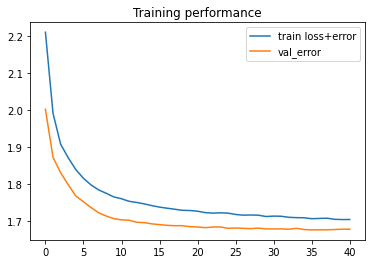

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

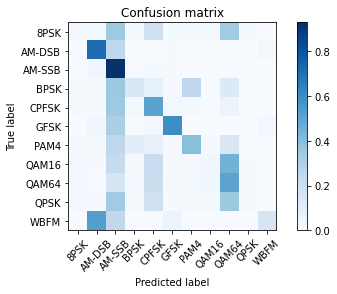

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08892921960072596


Overall Accuracy:  0.09121111446692842


Overall Accuracy:  0.09486640648453917


Overall Accuracy:  0.11762945225980245


Overall Accuracy:  0.13307532003572492


Overall Accuracy:  0.1851400730816078


Overall Accuracy:  0.24803387779794314


Overall Accuracy:  0.37192342752962626


Overall Accuracy:  0.4678926741031052


Overall Accuracy:  0.4908703590992088


Overall Accuracy:  0.5015479876160991


Overall Accuracy:  0.5054184226369657


Overall Accuracy:  0.4972136222910217


Overall Accuracy:  0.500459981600736


Overall Accuracy:  0.5001536098310292


Overall Accuracy:  0.49788391777509067


Overall Accuracy:  0.5104704097116843


Overall Accuracy:  0.5077380952380952


Overall Accuracy:  0.4881345749474317


Overall Accuracy:  0.5094569859670531


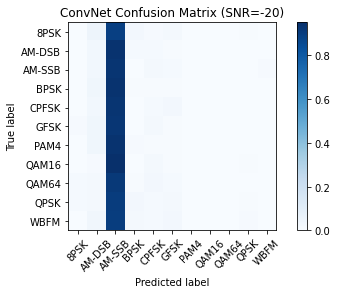

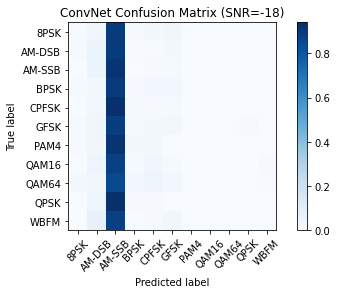

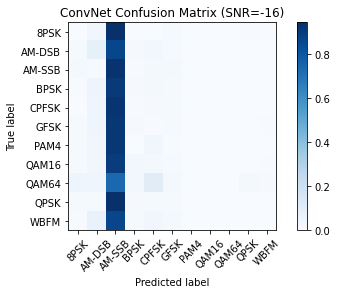

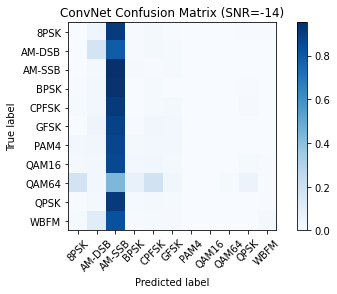

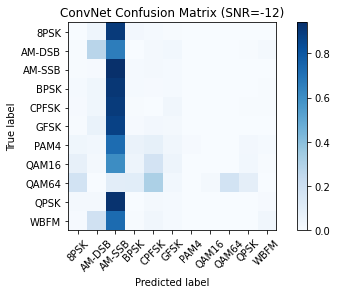

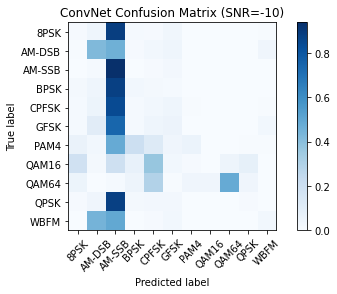

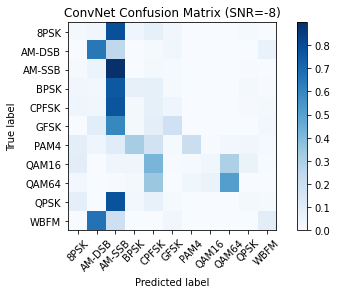

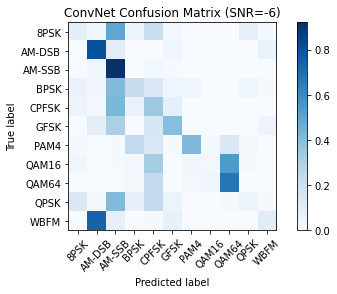

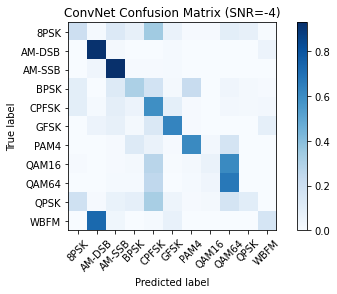

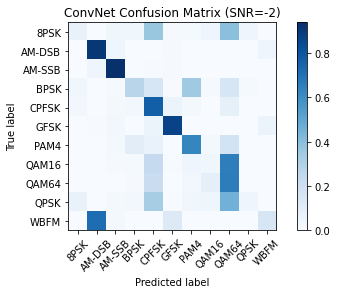

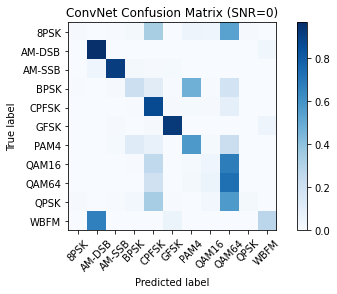

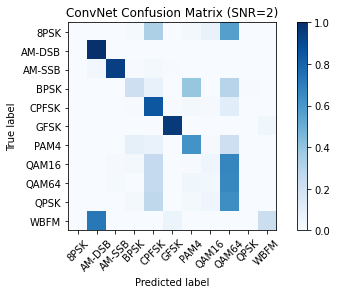

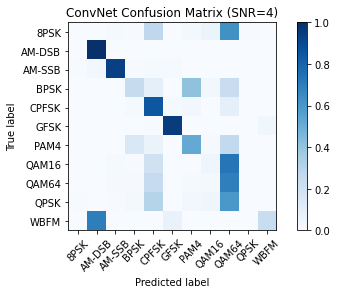

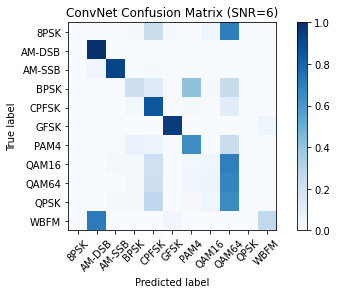

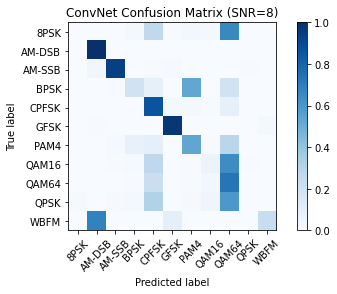

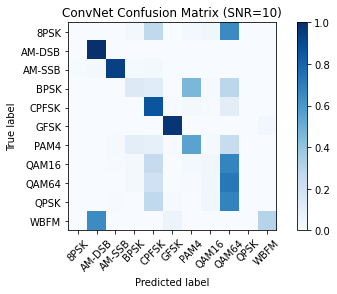

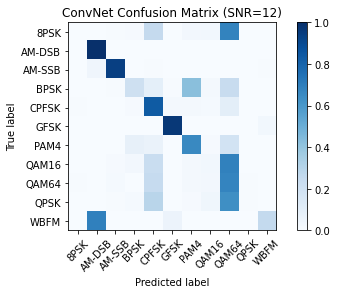

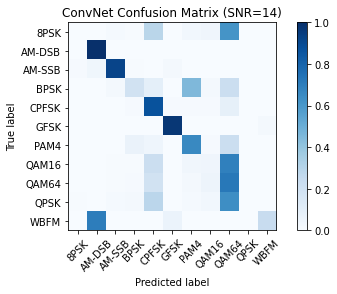

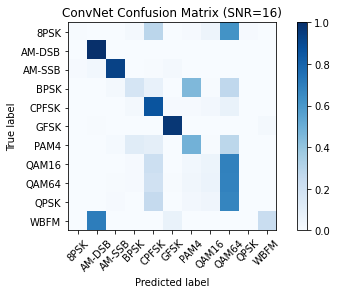

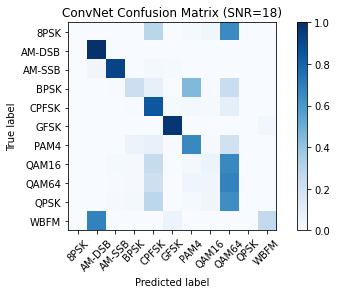

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,11,13,18,24,37,46,49,50,50,49,50,50,49,51,50,48,50


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

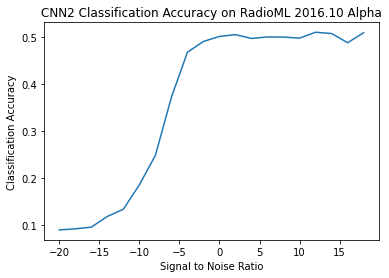

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")